## Анализ и прогнозирование временных рядов методами искусственного интеллекта

In [15]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### **Практическая работа 3. Поиск аномалий во временных рядах.**


#### **3.1 Поиск диссонансов с помощью алгоритма HotSAX**

In [16]:
!pip install saxpy

##### 3.1.1 Загрузка и подготовка данных

В данной будет использоваться временной ряд, состоящий из показаний акселерометра.
Анализируемый временной ряд, описывает две активности человека - бег и шаг.


In [17]:
!pip install scipy
!pip install scikit-learn

In [18]:
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from time import time
import pandas as pd

In [5]:
#fixme: Путь
dataset_dir_path = Path('datasets')/'/content/drive/MyDrive/2023-Elovikova-TimeSeriesCourse/practice/03 Discords/datasets/walk_run.txt'
data = np.loadtxt(dataset_dir_path)[3000:4000]
size_sub = 50


В середине временного ряда происходит смена активности (бег заменяет шаг). Нетипичным поведением, которое мы могли бы назвать диссонансами в данном ряде выступает небольшой участок между активностями, когда человек плавно увеличивает скорость шага до бега. В ходе данной работе наша задача выделить с помощью различных алгоритмов границы нашего диссонанса.

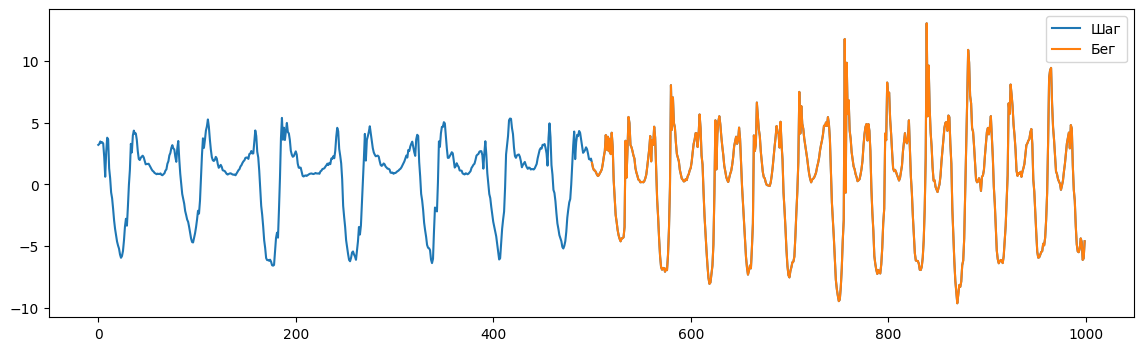

In [6]:
fig, ax =  plt.subplots(figsize=(14,4),ncols=1,nrows=1)
plt.plot(data[:],label='Шаг')
plt.plot(np.arange(data.shape[0]//2,data.shape[0]),data[data.shape[0]//2:],label='Бег')
plt.legend()

In [7]:
result={}
times={}

##### 3.1.2 Реализация полного перебора

Приводится пример кода для нахождения топ 5 диссонансов с помощью реализации полного беребора.
Вам необходимо добавить код для сбора времени обработки данных.

In [8]:
from saxpy.discord import find_discords_brute_force
start = time()
discords_brute_force= np.stack(find_discords_brute_force(data[:], 50, 5))
end = time()

In [9]:
time_brute_force = end - start
print(time_brute_force)
discords_brute_force


363.57698225975037


array([[477.        ,   5.88100934],
       [412.        ,   5.32704317],
       [195.        ,   3.39426635],
       [577.        ,   3.35554403],
       [278.        ,   3.10959389]])

##### 3.1.3 HotSAX

Используя [реализацию](https://github.com/seninp/saxpy/blob/master/saxpy/hotsax.py) найдите топ 5 диссонансов ряда.
Произведите замер времени работы.

In [10]:
#Implements HOT-SAX.
import numpy as np
from saxpy.znorm import znorm
from saxpy.sax import sax_via_window
from saxpy.distance import euclidean


def find_discords_hotsax(series, win_size=100, num_discords=2, alphabet_size=3,
                         paa_size=3, znorm_threshold=0.01, sax_type='unidim'):
    """Обнаружение разногласий на основе HOT-SAX."""
    discords = list()

    global_registry = set()

    # Z-нормализованные версии для каждой подпоследовательности.
    znorms = np.array([znorm(series[pos: pos + win_size], znorm_threshold) for pos in range(len(series) - win_size + 1)])

    # Слова SAX для каждой подпоследовательности.
    sax_data = sax_via_window(series, win_size=win_size, paa_size=paa_size, alphabet_size=alphabet_size,
                              nr_strategy=None, znorm_threshold=0.01, sax_type=sax_type)

    """[2.0] построить «волшебный» массив"""
    magic_array = list()
    for k, v in sax_data.items():
        magic_array.append((k, len(v)))

    """[2.1] отсортировать по возрастанию по количеству вхожденийs"""
    magic_array = sorted(magic_array, key=lambda tup: tup[1])

    while len(discords) < num_discords:

        best_discord = find_best_discord_hotsax(series, win_size, global_registry, sax_data, magic_array, znorms)

        if -1 == best_discord[0]:
            break

        discords.append(best_discord)

        mark_start = max(0, best_discord[0] - win_size + 1)
        mark_end = best_discord[0] + win_size

        for i in range(mark_start, mark_end):
            global_registry.add(i)

    return discords


def find_best_discord_hotsax(series, win_size, global_registry, sax_data, magic_array, znorms):
    """Найдите лучший дискорд с помощью hotsax."""

    """[3.0] определить ключевые переменные"""
    best_so_far_position = -1
    best_so_far_distance = 0.

    distance_calls = 0

    visit_array = np.zeros(len(series), dtype=np.int)

    """[4.0] и мы прекращаем перебор записей магического массива"""
    for entry in magic_array:

        """[5.0] текущие слова SAX и количество других последовательностей, сопоставленных с тем же словом SAX."""
        curr_word = entry[0]
        occurrences = sax_data[curr_word]

        """[6.0] проходя по одним и тем же вхождениям слов, легче
        зафиксировать, возможно, небольшое значение расстояния, чтобы мы могли работать эффективно
        и т.д...."""
        for curr_pos in occurrences:

            if curr_pos in global_registry:
                continue

            """[7.0] нам не нужна перекрывающаяся подпоследовательность"""
            mark_start = curr_pos - win_size + 1
            mark_end = curr_pos + win_size
            visit_set = set(range(mark_start, mark_end))

            """[8.0] вот наша подпоследовательность, о которой идет речь"""
            cur_seq = znorms[curr_pos]

            """[9.0] давайте посмотрим, что такое расстояние NN"""
            nn_dist = np.inf
            do_random_search = True

            """[10.0] упорядочен по вхождениям, искать в первую очередь"""
            for next_pos in occurrences:

                """[11.0] пропустить плохое сообщение"""
                if next_pos in visit_set:
                    continue
                else:
                    visit_set.add(next_pos)

                """[12.0] расстояние, которое мы вычисляем"""

                dist = euclidean(cur_seq, znorms[next_pos])
                distance_calls += 1

                """[13.0] поддерживать книги в актуальном состоянии"""
                if dist < nn_dist:
                    nn_dist = dist
                if dist < best_so_far_distance:
                    do_random_search = False
                    break

            """[13.0] если не сломано выше,
            мы продолжим случайный поиск"""
            if do_random_search:
                """[14.0] построить этот массив случайных заказов на посещение"""
                curr_idx = 0
                for i in range(0, (len(series) - win_size + 1)):
                    if not(i in visit_set):
                        visit_array[curr_idx] = i
                        curr_idx += 1
                it_order = np.random.permutation(visit_array[0:curr_idx])
                curr_idx -= 1

                """[15.0] и пойти наугад"""
                while curr_idx >= 0:
                    rand_pos = it_order[curr_idx]
                    curr_idx -= 1

                    dist = euclidean(cur_seq, znorms[rand_pos])
                    distance_calls += 1

                    """[16.0] поддерживать книги в актуальном состоянии снова"""
                    if dist < nn_dist:
                        nn_dist = dist
                    if dist < best_so_far_distance:
                        nn_dist = dist
                        break

            """[17.0] и БОЛЬШИЕ книги"""
            if (nn_dist > best_so_far_distance) and (nn_dist < np.inf):
                best_so_far_distance = nn_dist
                best_so_far_position = curr_pos

    return best_so_far_position, best_so_far_distance

In [11]:
from saxpy.hotsax import find_discords_hotsax

start = time()
discords_hotsax = find_discords_hotsax(data[:], num_discords=5, win_size=size_sub)
end = time()
time_hotsax=end-start
print(end - start, '\n')
discords_hotsax

10.097848653793335 



[(477, 5.881009341683914),
 (412, 5.327043167878002),
 (195, 3.394266347302333),
 (577, 3.3555440274836608),
 (278, 3.10959388763498)]

Постройте графики для обоих алгоритмов и сравните полученные результаты. Сделайте выводы

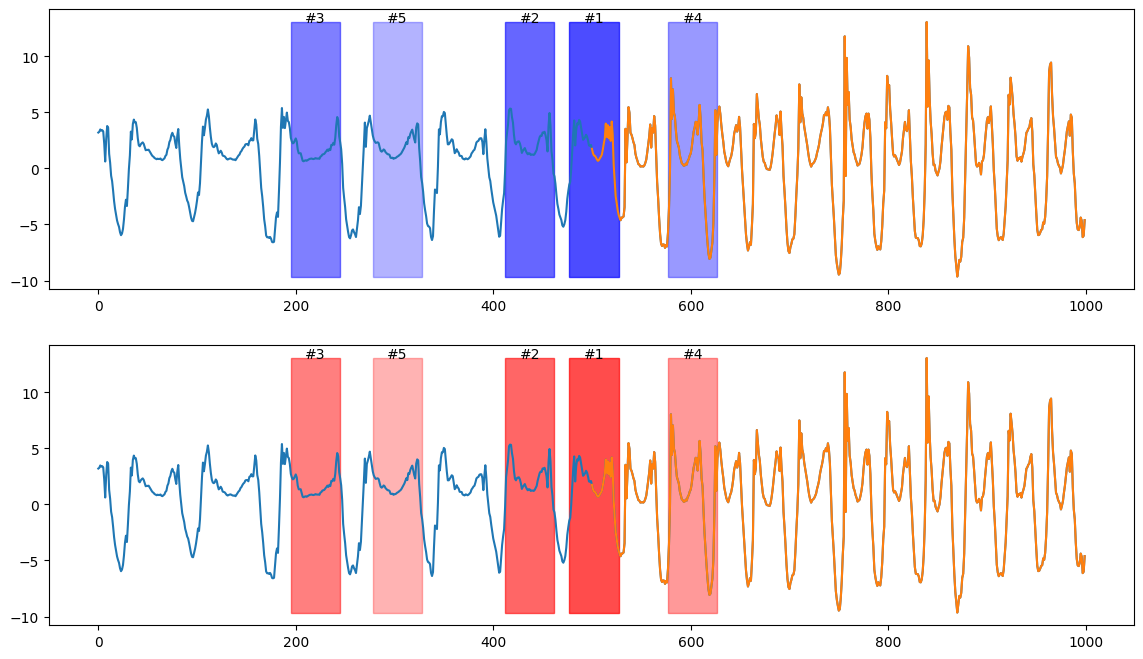

In [12]:
from matplotlib.patches import Rectangle
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8))
ax1.label = 'brute force'
ax2.label = 'hotsax'
mn, mx = min(data), max(data)

for i in range(len(discords_brute_force)):
    alpha = 1-(i+3)*0.1
    ax1.add_patch(Rectangle(xy=(discords_brute_force[i][0], mn), width=size_sub, height=mx-mn, color='blue', alpha=alpha))
    ax1.text(discords_brute_force[i][0]+size_sub/2, mx, f"#{i+1}", ha='center')
ax1.plot(data[:], label='Шаг')
ax1.plot(np.arange(data.shape[0]//2, data.shape[0]), data[data.shape[0]//2:], label='Бег')

for i in range(len(discords_hotsax)):
    alpha = 1-(i+3)*0.1
    ax2.add_patch(Rectangle(xy=(discords_hotsax[i][0], mn), width=size_sub, height=mx-mn, color='red', alpha=alpha))
    ax2.text(discords_hotsax[i][0]+size_sub/2, mx, f"#{i+1}", ha='center')
ax2.plot(data[:], label='Шаг')
ax2.plot(np.arange(data.shape[0]//2, data.shape[0]), data[data.shape[0]//2:], label='Бег')

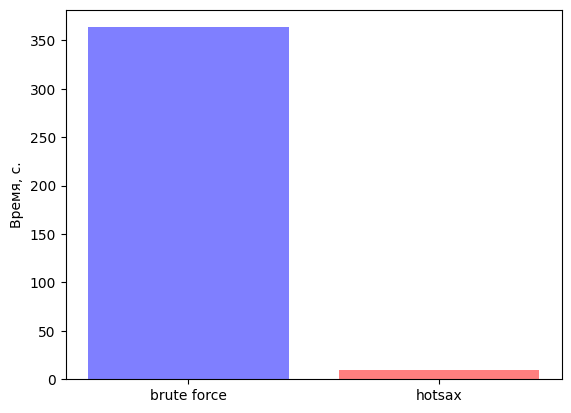

In [13]:
fig, ax = plt.subplots()
ax.bar(['brute force', 'hotsax'], [time_brute_force, time_hotsax], color=['blue', 'red'], alpha=0.5)
ax.set_ylabel('Время, с.');

## второй вариант, хуже

In [14]:
result_hotsax={}

In [15]:
# INSERT YOUR CODE
import timeit
import numpy as np
from saxpy.znorm import znorm
from saxpy.sax import sax_via_window
from saxpy.distance import euclidean
from saxpy.hotsax import find_discords_hotsax

# Замеряем время выполнения find_discords_hotsax
time_start = timeit.default_timer()
discords = find_discords_hotsax(data)
time_end = timeit.default_timer()

# Сортируем диссонансы и выводим топ 5
sorted_discords = sorted(discords, key=lambda x: x[1], reverse=True)
top_5_discords = sorted_discords[:5]

print("Топ 5 диссонансов ряда:")
for discord in top_5_discords:
    print(f"Индекс: {discord[0]}, Значение: {discord[1]}")

# Выводим время выполнения find_discords_hotsax
execution_time = time_end - time_start
print(f"\nВремя выполнения find_discords_hotsax: {execution_time} секунд")

Топ 5 диссонансов ряда:
Индекс: 467, Значение: 10.217683036861489
Индекс: 182, Значение: 9.38924388576003

Время выполнения find_discords_hotsax: 5.092946823000148 секунд


In [17]:
#data

array([ 3.1991567e+00,  3.2663387e+00,  3.4749122e+00,  3.3734364e+00,
        3.4144765e+00,  3.3085032e+00,  2.2233591e+00,  6.1512298e-01,
        2.5913141e+00,  3.7827126e+00,  3.6342937e+00,  1.2977653e+00,
        5.0288124e-01, -6.5450457e-01, -1.1348138e+00, -1.9791427e+00,
       -2.9200281e+00, -3.6154603e+00, -4.1531975e+00, -4.6400562e+00,
       -4.9610682e+00, -5.2148981e+00, -5.6888264e+00, -5.9558679e+00,
       -5.8153197e+00, -5.4046381e+00, -4.5593816e+00, -3.4411806e+00,
       -2.7946311e+00, -3.3517920e+00, -1.7953338e+00, -5.3332396e-02,
        1.1584821e+00,  3.2823612e+00,  2.5853830e+00,  3.9628953e+00,
        4.3564301e+00,  4.0950105e+00,  4.1290232e+00,  3.6185524e+00,
        2.6853127e+00,  2.0613352e+00,  1.9735488e+00,  2.1459452e+00,
        2.2495292e+00,  2.3224455e+00,  2.1893465e+00,  1.8895292e+00,
        1.6214758e+00,  1.6517498e+00,  1.6503725e+00,  1.6676599e+00,
        1.5288826e+00,  1.3738580e+00,  1.2168658e+00,  1.0960225e+00,
      

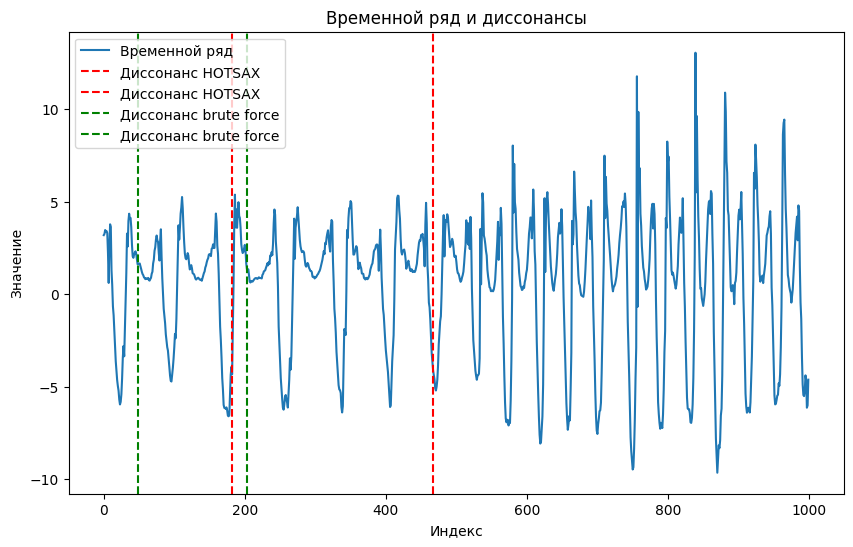

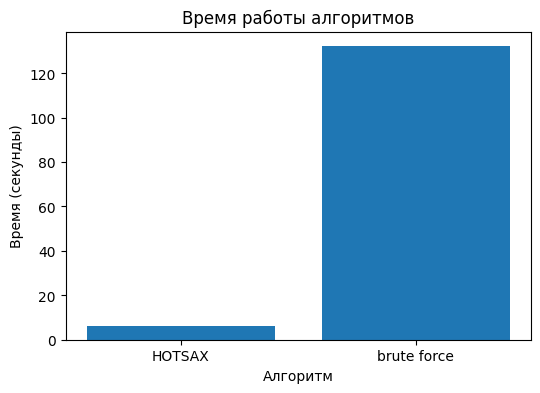

In [20]:
import timeit
import matplotlib.pyplot as plt
from saxpy.hotsax import find_discords_hotsax
from saxpy.discord import find_discords_brute_force

'''# Параметры алгоритмов
win_size = 3
num_discords = 2
alphabet_size = 3
paa_size = 3
znorm_threshold = 0.01
sax_type = 'unidim'

# Алгоритм HOTSAX
time_start_hotsax = timeit.default_timer()
discords_hotsax = find_discords_hotsax(data)
time_end_hotsax = timeit.default_timer()
execution_time_hotsax = time_end_hotsax - time_start_hotsax

# Алгоритм brute force
time_start_brute_force = timeit.default_timer()
discords_brute_force = find_discords_brute_force(data, win_size, num_discords)
time_end_brute_force = timeit.default_timer()
execution_time_brute_force = time_end_brute_force - time_start_brute_force

# График временного ряда и диссонансов
plt.figure(figsize=(10, 6))
plt.plot(data, label='Временной ряд')
for discord in discords_hotsax:
    plt.axvline(x=discord[0], color='r', linestyle='--', label='Диссонанс HOTSAX')
for discord in discords_brute_force:
    plt.axvline(x=discord[0], color='g', linestyle='--', label='Диссонанс brute force')
plt.legend()
plt.title('Временной ряд и диссонансы')
plt.xlabel('Индекс')
plt.ylabel('Значение')
plt.show()

# Столбчатая диаграмма времени работы алгоритмов
execution_times = [execution_time_hotsax, execution_time_brute_force]
labels = ['HOTSAX', 'brute force']

plt.figure(figsize=(6, 4))
plt.bar(labels, execution_times)
plt.title('Время работы алгоритмов')
plt.xlabel('Алгоритм')
plt.ylabel('Время (секунды)')
plt.show()'''

##### 3.1.4 Визаулизация

Вам необходимо реализовать код позволяющий:
1. Вывести на одном графике ряд и его диссонансы
2. Столбчатую диаграмму времени работы обоих алгоритмов
   
Постройте графики для обоих алгоритмов и сравните полученные результаты.

Пример графика:

![first_graf](pics/fig_ex_1.png)

In [ ]:
# INSERT YOUR CODE

In [21]:
from matplotlib.patches import Rectangle

# 3.1.5 Такси NY

Произведите поиск диссонансов с помощью обоих алгоритмов на наборе данных, содержащим информацию о среднем числе пассажиров в NY. Отобразите найденные диссонансы обоими алгоритмами.

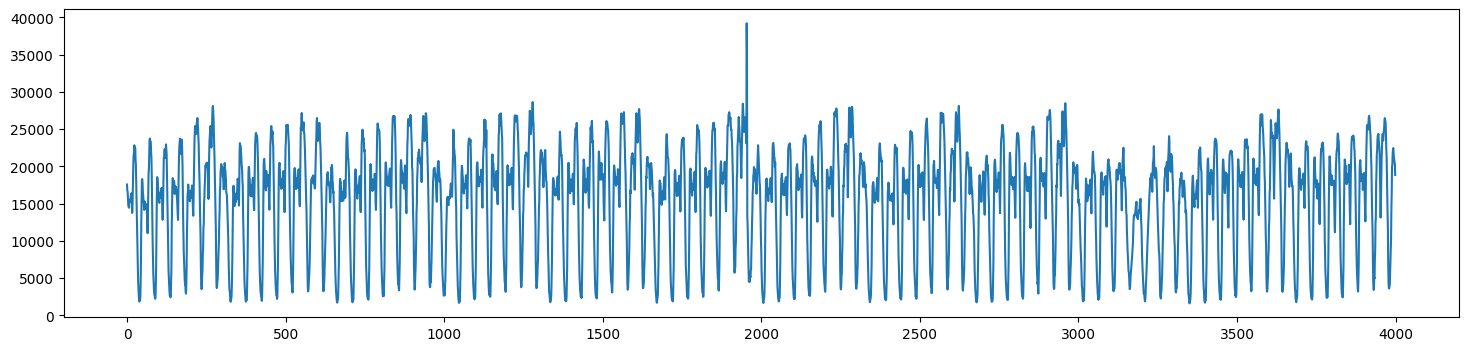

In [19]:
nyc_taxi = pd.read_csv('/content/drive/MyDrive/2023-Elovikova-TimeSeriesCourse/practice/03 Discords/datasets/nyc_taxi.csv',index_col=0).values[4000:8000,0].astype(np.float64)
fig = plt.figure(figsize=(18, 4))
plt.plot(nyc_taxi)

### INSERT YOUR CODE

In [21]:
start = time()
discords_brute_force = find_discords_brute_force(nyc_taxi[:], win_size=size_sub, num_discords=1)
end = time()
time_brute_1 = round(end-start)

In [22]:
start_sax = time()
discords_hotsax = find_discords_hotsax(nyc_taxi[:], num_discords=5, win_size=size_sub) # 38 seconds
end_sax = time()
time_sax = round(end_sax-start_sax)

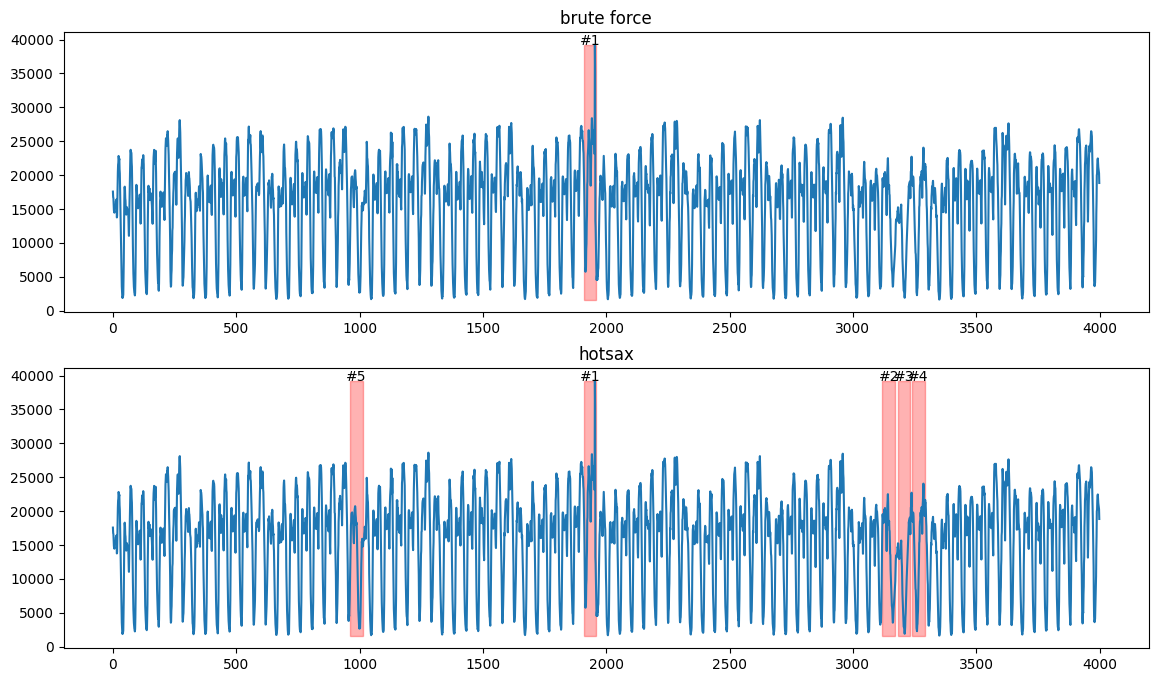

In [23]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8))
ax1.set_title('brute force')
ax2.set_title('hotsax')
mn, mx = min(nyc_taxi), max(nyc_taxi)

for i in range(len(discords_brute_force)):
    alpha = 0.3
    ax1.add_patch(Rectangle(xy=(discords_brute_force[i][0], mn), width=size_sub, height=mx-mn, color='red', alpha=alpha))
    ax1.text(discords_brute_force[i][0]+size_sub/2, mx, f"#{i+1}", ha='center')
ax1.plot(nyc_taxi)

for i in range(len(discords_hotsax)):
    alpha = 0.3
    ax2.add_patch(Rectangle(xy=(discords_hotsax[i][0], mn), width=size_sub, height=mx-mn, color='red', alpha=alpha))
    ax2.text(discords_hotsax[i][0]+size_sub/2, mx, f"#{i+1}", ha='center')
ax2.plot(nyc_taxi)

In [24]:
print('bruteforce',time_brute_1)
print('hotsax', time_hotsax)

bruteforce 1764
hotsax 10.097848653793335


## Вывод 3.1.5
Поиск диссонансов с помощью алгоритма HotSAX намного быстрее поиска методом перебора, в данном случае в тысячу раз

## Мои эксперименты

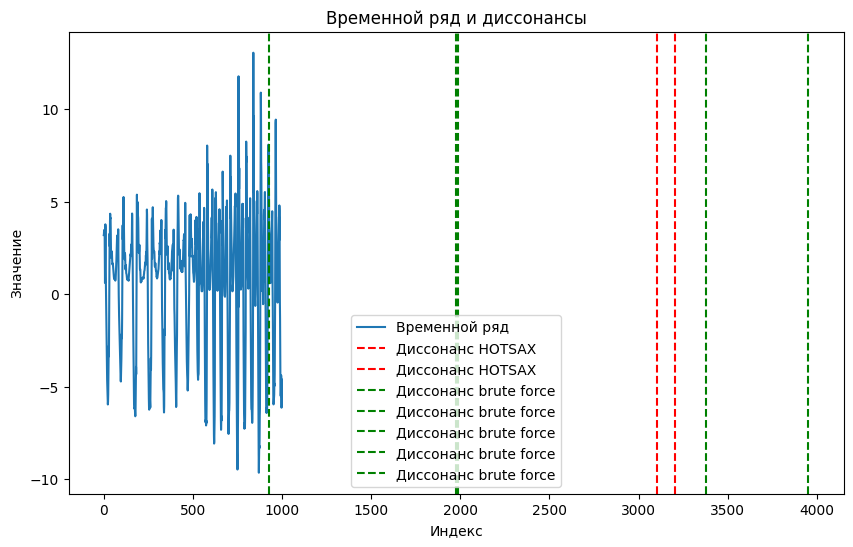

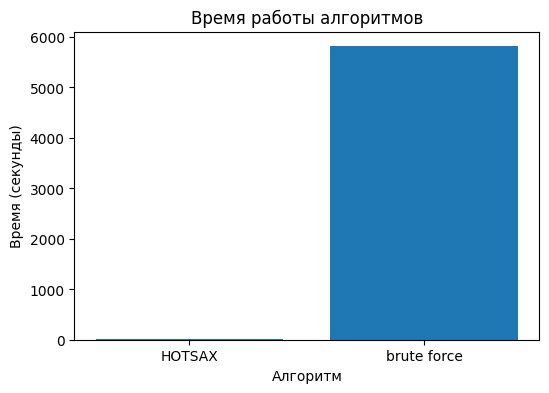

In [25]:
import timeit
import matplotlib.pyplot as plt
from saxpy.hotsax import find_discords_hotsax
from saxpy.discord import find_discords_brute_force

'''# Параметры алгоритмов
win_size = 3
num_discords = 5
alphabet_size = 3
paa_size = 3
znorm_threshold = 0.01
sax_type = 'unidim'

# Алгоритм HOTSAX
time_start_hotsax = timeit.default_timer()
discords_hotsax = find_discords_hotsax(nyc_taxi)
time_end_hotsax = timeit.default_timer()
execution_time_hotsax = time_end_hotsax - time_start_hotsax

# Алгоритм brute force
time_start_brute_force = timeit.default_timer()
discords_brute_force = find_discords_brute_force(nyc_taxi[:], win_size, num_discords)
time_end_brute_force = timeit.default_timer()
execution_time_brute_force = time_end_brute_force - time_start_brute_force

# График временного ряда и диссонансов
plt.figure(figsize=(10, 6))
plt.plot(data, label='Временной ряд')
for discord in discords_hotsax:
    plt.axvline(x=discord[0], color='r', linestyle='--', label='Диссонанс HOTSAX')
for discord in discords_brute_force:
    plt.axvline(x=discord[0], color='g', linestyle='--', label='Диссонанс brute force')
plt.legend()
plt.title('Временной ряд и диссонансы')
plt.xlabel('Индекс')
plt.ylabel('Значение')
plt.show()

# Столбчатая диаграмма времени работы алгоритмов
execution_times = [execution_time_hotsax, execution_time_brute_force]
labels = ['HOTSAX', 'brute force']

plt.figure(figsize=(6, 4))
plt.bar(labels, execution_times)
plt.title('Время работы алгоритмов')
plt.xlabel('Алгоритм')
plt.ylabel('Время (секунды)')
plt.show()'''

# **3.2 Поиск диссонансов с помощью алгоритма DRAG**

In [25]:
!pip install stumpy==1.11.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 136.2/136.2 kB 3.0 MB/s eta 0:00:00


In [29]:
import stumpy
from stumpy import core, config
from stumpy.scrump import _prescrump
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import time

Как мы помним из лекций:

**Диапазонный диссонанс** – подпоследовательность ряда, расстояние от которой до ее ближайшего соседа не ниже заданного порога.

Основными параметрами при поисках диссонансов являются:
- $m$ - длина диссонанса
- $r$ - пороговое значение расстояния подпоследовательности ряда, до его ближайшего соседа


In [34]:
import os
os.chdir('/content/drive/MyDrive/2023-Elovikova-TimeSeriesCourse/practice/03 Discords')
%load_ext autoreload
%autoreload 2
from modules.drag import *


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Для поиска диссонансов в данной части практической работы мы воспользуемся алгоритмом **DRAG (Discord Range Aware Gathering)**.
Для начала воспользуемся данным алгоритмом, чтобы найти диссонансы в наборе данных содержащем активность человека.

In [36]:
#data = walk_run

Длину искомого диссонанса, как и для предыдущих алгоритмов, мы установим равно 50 точек.
Пороговое значение мы установим равным большим, чтобы узнать, как алгоритм отреагирует на большие значения данного параметра.

In [ ]:
m = 50
r = 10
idxs, _, _ = DRAG(data,m,r)
print(f'Колличество найденных диссонансов: {len(idxs)}')

Колличество найденных диссонансов: 0


Как вы можете видеть мы установили слишком большое пороговое значение, алгоритму не удалось выделить ни одного диссонанса. Попробуем уменьшить пороговое значение до 1, чтобы улучшить результат.

In [ ]:
m = 50
r = 1
idxs, _, _ = DRAG(data, m, r)
print(f'Колличество найденных диссонансов: {len(idxs)}')

Колличество найденных диссонансов: 50


При такой комбинации параметров, улучшить ситуацию не получилось. Алгоритм выделил слишком большое количество диссонансов, часть которых является ложными диссонансами и не будут информативными для нас.

Произведите подобные эксперименты с набором данных такси NY. Постройте графики демонстрирующие найденные диссонансы. Пример Графика:
![second-graph](pics/fig_ex_2.png)

In [37]:
# INSERT YOUR CODE
data = nyc_taxi
m = 50
r = 10
idxs, _, _ = DRAG(data,m,r)
print(f'Колличество найденных диссонансов: {len(idxs)}')

Колличество найденных диссонансов: 0


In [38]:
m = 50
r = 1
idxs, _, _ = DRAG(data,m,r)
print(f'Колличество найденных диссонансов: {len(idxs)}')

Колличество найденных диссонансов: 42


Чтобы разобраться, почему так происходит и как работает данный алгоритм, ниже мы реализуем все этапы алгоритма DRAG.

Как мы помним из лекций алгоритм DRAG содержит два этапа:

1. Отбор - За одно сканирование ряда сформировать множество кандидатов в диссонансы.
2. Очистка - За одно сканирование ряда отбросить кандидатов, которые являются ложными диссонансами.

##### 3.2.1 Отбор кандидатов

Первым этапом обработки данных является отбор множества потенциальных кандидатов. Мы выбираем из всего множества подпоследовательностей ряда такие, для которых расстояние до правых ближайших соседей больше параметра $r$.

In [45]:
#выбирем более реальное значение для порога
r = 3
data = nyc_taxi

In [46]:
T, M_T, Σ_T = core.preprocess(data, m)
#формируем массив длинной равной длине  исходного ряда - m + 1,
#элемент массива является истинным,
#в том случае если подпоследовательность является потенциальным кандидатом
is_cands = find_candidates(T, m, M_T, Σ_T, r, init_cands=None, right=True)
#находим индексы потенциальных кандидатов
cand_index = np.flatnonzero(is_cands)

In [47]:
print(f'{len(cand_index)} {len(cand_index)/len(data)*100} %')

119 2.9749999999999996 %


Во время отбора кандидатов нам удалось выделить около 113 подпоследовательностей(около 11.3%), которые мы бы могли назвать потенциальными диссонансами.
Это большой процент, который не может нас устраивать как конечный результат.
Если посмотреть на рисунок ниже, мы увидим, что большая часть потенциальных диссонансов расположена в районе смены активности.
К сожалению пресутсвуют и ложные диссонансы, которые случайным образом попали в данный список.

Сформируйте график найденных диссонансов

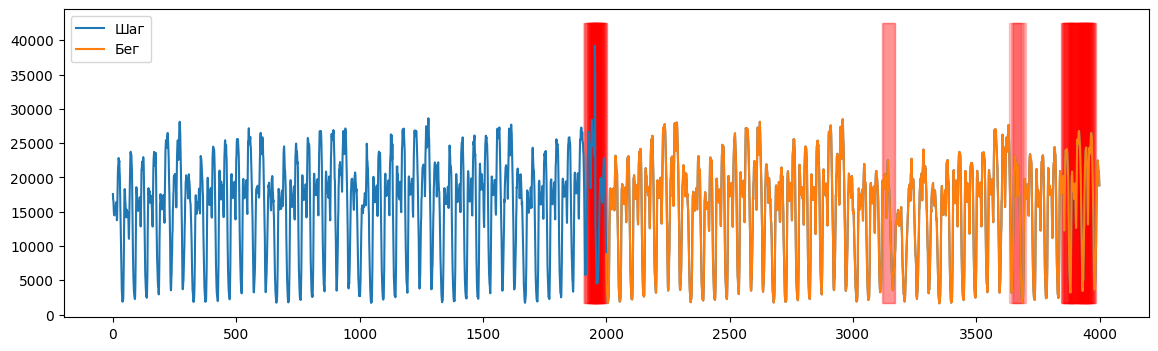

In [48]:
# INSERT YOUR CODE
fig, ax =  plt.subplots(figsize=(14,4),ncols=1,nrows=1)
plt.plot(data[:],label='Шаг')
plt.plot(np.arange(data.shape[0]//2,data.shape[0]),data[data.shape[0]//2:],label='Бег')
max_ = np.max(data[:])
min_ = np.min(data[:])
for indx, discord in enumerate(cand_index):
    ax.add_patch(Rectangle((discord,min_),m,
                            max_+np.abs(min_),
                                                    color='red',
                                                    alpha=0.1))
plt.legend()

##### 3.2.2 Очистка кандидатов
Как уже упоминалось выше, 11.3% слишком большой процент диссонансов.
Для уменьшения числа потенциальных кандидатов произведем очистку от ложных диссонансов, путем сравнения расстояния до левых ближайших соседей потенциальных диссонансов с порогом $r$.


In [49]:
is_cands = find_candidates(T, m, M_T, Σ_T, r, init_cands=is_cands, right=False)
cands = np.flatnonzero(is_cands)

In [50]:
len(cands)/len(data)*100

1.15

Сформируйте график найденных диссонансов

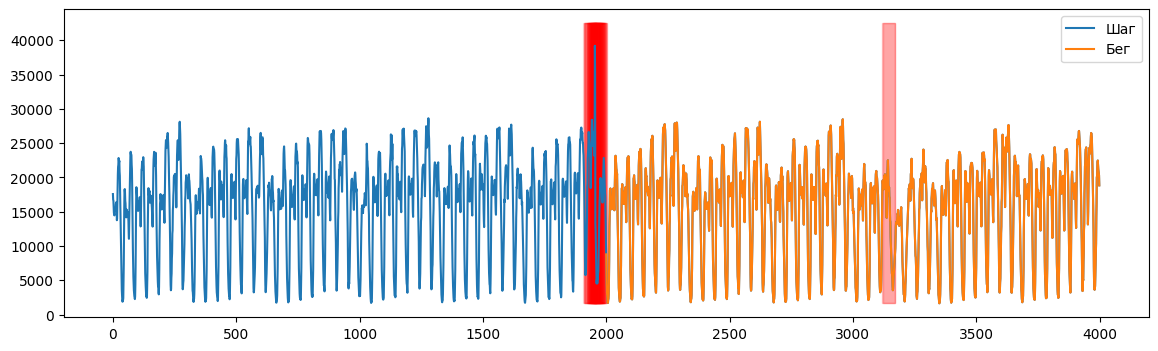

In [52]:
# INSERT YOUR CODE
fig, ax =  plt.subplots(figsize=(14,4),ncols=1,nrows=1)
plt.plot(data[:],label='Шаг')
plt.plot(np.arange(data.shape[0]//2,data.shape[0]),data[data.shape[0]//2:],label='Бег')
max_ = np.max(data[:])
min_ = np.min(data[:])
for indx, discord in enumerate(cands):
    ax.add_patch(Rectangle((discord,min_),m,
                            max_+np.abs(min_),
                                                    color='red',
                                                    alpha=0.1))
plt.legend()


Нам удалось сократить число диссонансов до 2.9%. Если проанализировать рисунок, то можно заметить, что большая их часть является тривиальными повторениями подпоследовательности в области смены активности. На следующем шаге избавимся от них.

In [53]:
from modules.drag import refine_candidates
discords_idx, discords_dist, discords_nn_idx = refine_candidates(T, m, M_T, Σ_T, is_cands)
len(discords_idx)/len(data)*100

0.1

Сформируйте график найденных диссонансов

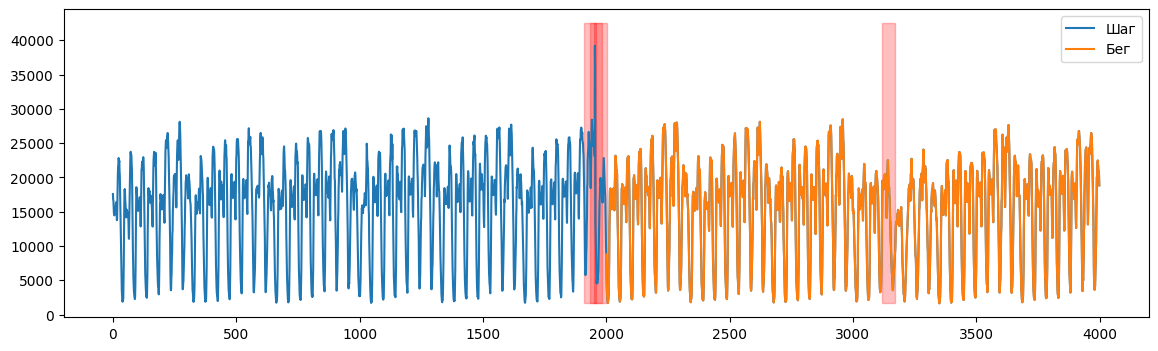

In [54]:
# INSERT YOUR CODE
fig, ax =  plt.subplots(figsize=(14,4),ncols=1,nrows=1)
plt.plot(data[:],label='Шаг')
plt.plot(np.arange(data.shape[0]//2,data.shape[0]),data[data.shape[0]//2:],label='Бег')
max_ = np.max(data[:])
min_ = np.min(data[:])
for indx, discord in enumerate(discords_idx):
    ax.add_patch(Rectangle((discord,min_),m,
                            max_+np.abs(min_),
                                                    color='red',
                                                    alpha=0.25))
plt.legend()

##### 3.2.3 Подбор параметров

Реализуйте перебор параметров $m$ и $r$. Подберете параметры таким образом, чтобы алгоритм обнаружил только те диссонансы, которые связаны со сменой активности. Сделайте вывод о том, как эти параметры влияют на качество работы модели.
Подберите оптимальные параметры алгоритма для набора данных такси NY.
Визуализируйте результаты для разных комбинаций. Сделайте выводы.


In [ ]:
# INSERT YOUR CODE

# **3.3 Поиск диссонансов с помощью алгоритма Merlin**

Как мы уже выяснили подбирать параметры для DRAG простым перебором не очень удобно. Для оптимизации данного процесса в статье [1] был предложен алгоритм Merlin для оптимального поиска подходящего порогового значения.

Условно мы можем разделить поиск диссонансов на три шага:

1. Поиск диссонансов минимальной длинны $minL$. На данном шаге $r = 2\sqrt{minL}$.
2. Поиск диссонансов следующих четырех длин. На данном шаге $r = 0.99 \cdot nndist_{m-1}$. Где $nndist_{m-1}$ - расстояние до ближайшего соседа предыдущего найденного диссонанса.
3. Поиск диссонансов всех
оставшихся дли. $r = \mu - 2 \sigma$. Средние значение и стандартное отклонение вычисляются из расстояний 5 предыдущих диссонансов. н

[1] Nakamura T., Imamura M., Mercer R., Keogh E.J. MERLIN: parameter-free discovery of arbitrary length anomalies in massive time series archives. 20th IEEE Int. Conf. on Data Mining, ICDM 2020, Sorrento, Italy, November 17-20, 2020. pp. 1190-1195. IEEE (2020). https://doi.org/10.1109/ICDM50108.2020.00147

##### 3.3.1 Поиск диссонансов минимальной длинны

Вспомнил последовательность действий первого шага алгоритма:
![merlin-part-first](pics/first_part.png)

В данной работе мы внесем небольшое изменение, мы будем считать, что подпоследовательность может быть диссонансом только в том случае, если больше 75% точек, не входят в состав других диссонансов.

In [ ]:
T = walk_run
m = 50
# сформируем массив метод для потенциальных кандидатов в диссонансы.
# после каждого найденного диссонанса,
# мы будем исключать окружающие его подпоследовательности из числа потенциальных кандидатов,
# путем замены значений их меток на false
excl_zone = int(np.ceil(m / 4))
include = np.ones(len(T)-m+1, dtype=bool)
# Количество диссонансов, которые мы будем искать
topK = 10


In [ ]:
dis_idx = -np.ones((topK))
dis_nnDist = -np.ones((topK))
dis_nn_idx = np.full((topK),-np.inf)
#первое прближение r
r = 2*np.sqrt(m)
minL = m
maxL = int(m+np.ceil(m*0.1))
#количество найденных диссонасов
cound_find_dis = 0

while dis_nnDist[cound_find_dis-1]<0 and cound_find_dis<topK:
    result = DRAG(data=T,m=minL,r=r, include =include)
    for diss, nnDist, nn in zip(*result):
        dis_idx[cound_find_dis] = diss
        dis_nnDist[cound_find_dis] = nnDist
        dis_nn_idx[cound_find_dis] = nn
        #исключаем окружающие найденный диссонас
        #подпоследовательности и числа потенциальных диссонасов
        core.apply_exclusion_zone(include, diss, excl_zone, False)
        cound_find_dis+=1
        if cound_find_dis>=topK:
            break
    r*=0.5

In [ ]:
maxL

55

In [ ]:
print('Количество найденных на первом этапе диссонансов:', cound_find_dis)

Количество найденных на первом этапе диссонансов: 2


На первом шаге нам удалось выделить 2 диссонанса из 10 требуемых.
Реализуйте, оставшиеся шаги алгоритма, чтобы найти оставшиеся диссонансы.

![merlin-part-first](pics/second_part.png)


In [ ]:
# INSERT YOUR CODE

Найдите диссонансы набора такси NY. Визуализируйте найденные диссонансы для обоих наборов данных, сравните с результатами остальных методов.


In [ ]:
# INSERT YOUR CODE